![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true' alt='Practicum AI: Computer Vision icon' align='right' width=50>
***

# Computer Vision Concepts

You may recall *Practicum AI*'s heroine Amelia, the AI-savvy nutritionist. At the end of our *[Deep Learning Foundations course](https://practicumai.org/courses/deep_learning/)*, Amelia was helping with a computer vision project. Her colleague, an entomologist named Kevin, had a dataset of images of bees and wasps and wanted to classify them.

![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning/blob/main/images/bees_wasps_dataset-cover.png?raw=true)


## AI Pathway review for Bees vs Wasps

If you have taken out [Getting Started with AI course](https://practicumai.org/courses/getting_started/), you may remember this figure of the AI Application Development Pathway. Let's take a quick review of how we applied this pathway in the case of the Bees vs Wasps example.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we need to classify images as bees, wasps, other insects, or a non-insect. 
2. **Gather data:** The data for the example come from [Kaggle](https://www.kaggle.com/), a great repository of datasets, code, and models.
3. **Clean and prepare the data:** In the *Deep Learning Foundations* course, we assumed that this was done for us. One issue that we ran into was that of class imbalance. There are many more images in some classes than others, leading to a poor performing model.
4. **Choose a model:** In the *Deep Learning Foundations* course, we presented the model with little detail. Now that we know more about Convolutional Neural Networks and some other tools are our disposal, we will explore the model in more detail.
   * As part of the iterative process among this and the next steps, one thing we noticed is that most of our models were overfitting—performing better on the training data than they did on the testing data. Essentially, the models memorized the training data but did not generalize well to new data that had not been seen. 
      * In this notebook, we will explore **dropout** as one mechanism to mitigate overfitting.
5. **Train the model:** In training the model we may have had a few issues. With so many hyperparameters to tune, it's easy to lose track of what combinations have been tried and how changes impacted model performance. 
   * In this notebook, we introduce you to [TensorBoard](https://www.tensorflow.org/tensorboard), one popular tool in a class of tools known as **experiment tracking** or **MLOps tools**. These tools help track changes to hyperparameters, the training process, and the data. They allow comparison among runs and can even automate multiple runs for you. Learning to use MLOps tools will help you as you continue to learn more about AI workflows.
6. **Evaluate the model:** We will continue to assess how the model performs on the test set and adjust the model and hyperparameters to attempt to produce a better model. However, as noted above in step 3, one issue is the class imbalance.    
   * This is a common issue with real data, and in notebook [01.2_stratification.ipynb](01.2_stratification.ipynb), we will explore some methods to handle this.
7. **Deploy the model:** We won't get to this stage in this exercise, but hopefully, we will end up with a model that could be deployed and achieve relatively good accuracy at solving the problem.


## A refresher

If you need a refresher, or haven't taken the *Deep Learning Foundations* course, the final notebook is part of this repository: [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb). However, we will cover what we did before and the new changes as we work through this notebook. Some of the code has been moved into the [helpers_01.py](helpers_01.py) file and is imported below to keep things cleaner.



## 1. Import the libraries we will use

In [1]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
import datetime

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.

 
# Import Keras libraries
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhace readability. 
import helpers_01

Matplotlib is building the font cache; this may take a moment.


## 2. Jupyter magic commands

In Jupyter, the `%` is used as a "magic" command. These extend Python on various ways. In this case, Tensorboad functionality is added using `%load_ext tensorboard`

Again, [Tensorboard](https://www.tensorflow.org/tensorboard) is the MLOps tool we'll use for experiment tracking in many of these notebooks. 

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## 3. Getting the data

Check the "Getting the data" section of [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb#2.-Getting-the-data) for details about the dataset and the code used to getting the data if neede. Or you can look at the [helpers_01.py file](helpers_01.py). 

If you need to download the data, it is [hosted for download from Dropbox here as a `tar.gz` file](https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=0). If you need to manually extract the data, you can add a cell and run: `helpers_01.extract_file("bee_vs_wasp.tar.gz", "data")`


In [3]:
# Check for the data.
# This will look for the data files required for this notebook in some common locations.
# If it can't find the data, it will ask if you know where it is. If you do, answer yes and 
# provide the path to the data (up to and including the `bee_vs_wasp` folder name). If not, 
# it will ask if you want to download it. If you answer yes, it will download the data and 
# extract it into your data folder.""

data_path = helpers_01.manage_data()    

Found data at /blue/practicum-ai/share/data/bee_vs_wasp.


## 4. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.

The `helpers_01.load_display_data` function takes: 
* A path to the data--set from above.
* The batch size--set as 32 below, but a good hyperparameter to tune.
* Target shape for images--set as 80*80 color images below, another possible hyperparameter.
* Whether or not to show sample images.

It returns training and testing datasets. To help highlight the class imbalance issue, the function has been updated to report the numbers of images and percent of the total in each class.


***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Returning class counts for later use? False
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.


2024-07-10 13:57:49.300059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 13:57:49.978260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:da:00.0, compute capability: 7.5


Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


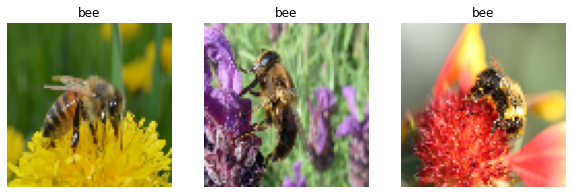

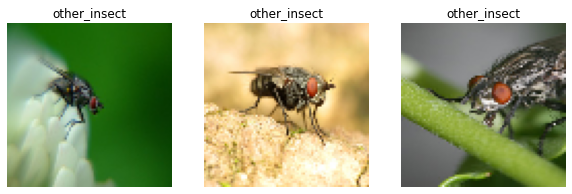

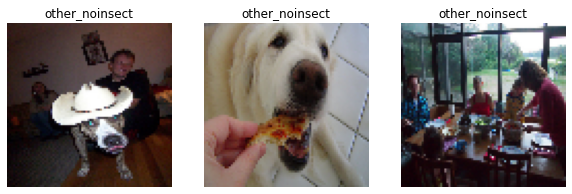

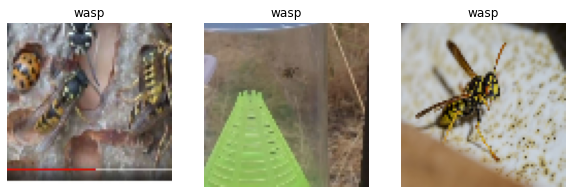


Getting number of images per class. This may take a bit...

For the Training set:
Category bee: 2552 images or 27.9% of total images.
Category other_insect: 1945 images or 21.3% of total images.
Category other_noinsect: 698 images or 7.6% of total images.
Category wasp: 3943 images or 43.1% of total images.


In [4]:
# The data path should be set from the cell above. 
# If that failed and you want to set it manually, use the line below.
# data_path= "data/bee_vs_wasp"

X_train, X_test = helpers_01.load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=True)


## 5. Set hyperparameters

In [5]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = False # We'll turn this off, but change to True if you want them...

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=False) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs


## 6. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [6]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                          

## 7. Compile and Train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

### Add a TensorBoad callback

In Tensorflow, callbacks can be used during model training to control a number of things, like changing the learning rate each epoch, stopping training if model accuracy hasn't improved a set amount over a set number of epochs, etc. In this case, we will use a callback to log training data to a folder for TensorBoard to analyze.

We'll set the log path, adding the hyperparameter values we want to keep track of as part of the path name.

In [7]:

# Set dropout variable to "No_dropout" since we haven't added dropout to the model yet
dropout = "No_dropout" 
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model, history = helpers_01.compile_train_model(X_train, X_test, model, callbacks=tensorboard_callback)

***********************************************************************
Compile and Train the model:
  - Using the loss function: <keras.losses.SparseCategoricalCrossentropy object at 0x147f6b321ee0>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
  - Using these callbacks: <keras.callbacks.TensorBoard object at 0x147eff161160>
***********************************************************************
Epoch 1/10


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2024-07-10 13:58:13.695933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


286/286 [==============================] - 27s 86ms/step - loss: 2.3284 - accuracy: 0.5652 - val_loss: 1.0513 - val_accuracy: 0.6331
Epoch 2/10
286/286 [==============================] - 25s 85ms/step - loss: 0.8659 - accuracy: 0.6852 - val_loss: 0.8699 - val_accuracy: 0.6865
Epoch 3/10
286/286 [==============================] - 24s 82ms/step - loss: 0.6590 - accuracy: 0.7516 - val_loss: 0.8616 - val_accuracy: 0.6891
Epoch 4/10
286/286 [==============================] - 24s 84ms/step - loss: 0.5253 - accuracy: 0.8049 - val_loss: 0.8201 - val_accuracy: 0.7189
Epoch 5/10
286/286 [==============================] - 27s 91ms/step - loss: 0.4189 - accuracy: 0.8484 - val_loss: 0.7803 - val_accuracy: 0.7176
Epoch 6/10
286/286 [==============================] - 24s 84ms/step - loss: 0.3471 - accuracy: 0.8780 - val_loss: 0.8378 - val_accuracy: 0.7167
Epoch 7/10
286/286 [==============================] - 22s 74ms/step - loss: 0.2608 - accuracy: 0.9104 - val_loss: 0.7647 - val_accuracy: 0.7426
Epo

## 8. Evaluate the model

Now that we have trained our model let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 5s 56ms/step - loss: 0.8286 - accuracy: 0.7566
Test loss: 0.828589141368866
Test accuracy: 0.7565674185752869


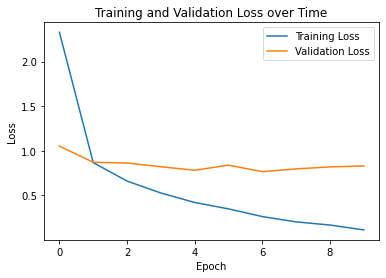

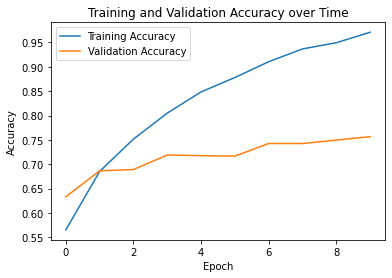

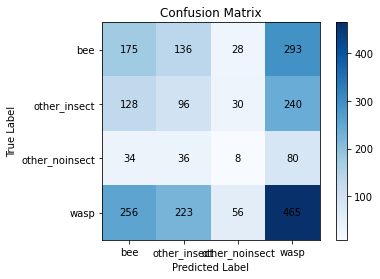

In [8]:

helpers_01.evaluate_model(X_train, X_test, model, history)


## 9. View training metrics in TensorBoard

Now that we've run one training cycle, we can open TensorBoard and have a look at the visualizations it provides to evaluate training performance.

The detailed instructions for different platforms are in the course content. In general, we use the `tensorboard --logdir ./logs` command to start TensorBoard and then connect in a Web browser. Here's a screenshot of what that might look like:

![Screenshot of the TensorBoard web page](images/tensorboard_screenshot.png)



## 10. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [9]:
def the_whole_shebang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_test = helpers_01.load_display_data(data_path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    
    # Set dropout variable to "No_dropout" since we haven't added dropout to the model yet
    dropout = "No_dropout" 
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model, history = helpers_01.compile_train_model(X_train, X_test, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs, callbacks=tensorboard_callback)
    helpers_01.evaluate_model(X_train, X_test, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 64.
  - Resizing input images to: (80, 80, 3).
  - Returning class counts for later use? False
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


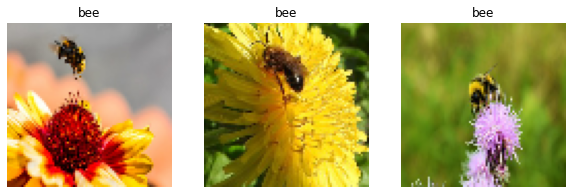

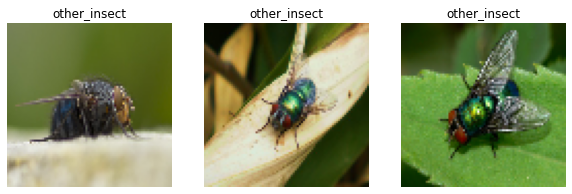

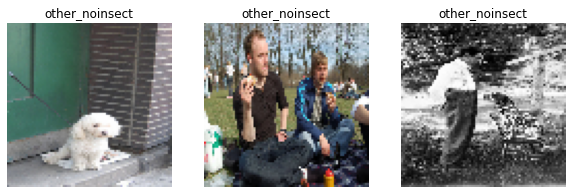

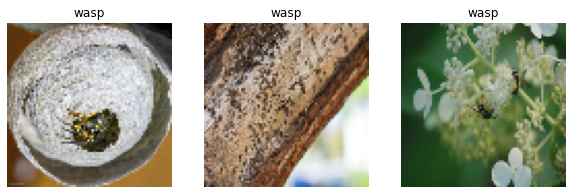


Getting number of images per class. This may take a bit...

For the Training set:
Category bee: 2552 images or 27.9% of total images.
Category other_insect: 1945 images or 21.3% of total images.
Category other_noinsect: 698 images or 7.6% of total images.
Category wasp: 3943 images or 43.1% of total images.
***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss function: <keras.losses.SparseCategoricalCrossentropy object at 0x147ec4667d60>.
  - Using the optimizer: Adagrad.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
  - Using these callbacks: <keras.callbacks.TensorBoard object at 0x147ec4661670>
********************************

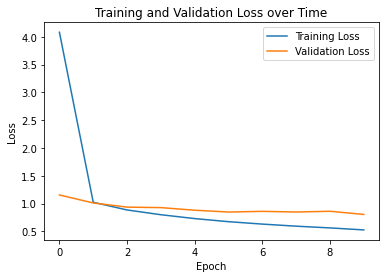

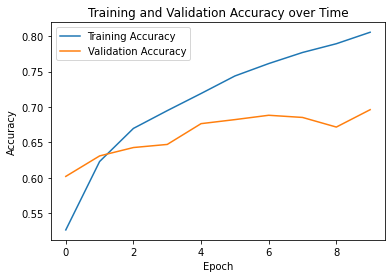

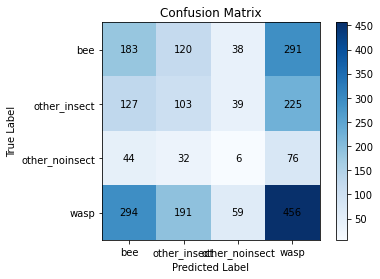

In [10]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 64  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=False) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

## 11. Summary so far

Some of the points we can take away so far:

* Most of the time, our model struggles to do better than about 70% accuracy on the validation data. Accuracy on the training data is closer to 90%. This suggests that our model is overfitting the training data.
* Additionally, while 70% doesn't sound too bad, the confusion matrix makes it clear that the model favors predicting the wasp category--more images from the other categories are classified as wasp than the correct cateregory.
* This highlights the need to look at different measures of accuracy! What measure is most important can depend on the situation and the implications of making mistakes of different kinds.

Before we move on to working more to improve the model, let's take a quick look at the inner workings of the convolutional kernels.


## 12. A look inside CNNs
To get an idea for what is happening *inside* this model, let's look at a **feature map**. Below we see a vertical edge detection filter applied to a sunflower picture, resulting in a feature map of that image.

![Two pictures of a sunflower. On the left is the original image, on the right is the convolved image resulting from applying an edge detecting convolutional filter.](images/filtered_sunflower_nb01.jpg)

Imagine you're a detective investigating a scene.  A feature map is like a sketch you create, focusing on specific details that might be clues to solving the case.  In a CNN, the "case" is recognizing patterns in an image, and the feature maps capture these patterns at different levels of complexity. Early layers might create feature maps that detect basic edges, corners, or blobs of color. As the network progresses through more layers, the feature maps become more intricate, combining these simpler features to represent more complex objects or shapes.

Getting a bit more technical, a feature map is a 2D array of activations produced by applying a convolutional filter to an input image or a previous layer's feature map. It essentially captures the presence and strength of specific visual features the filter is optimized to detect within the input.

The **convolutional filters** (also just called "filters" or "kernels") are small matrices containing learnable weights. The filter "slides" across the input image, performing element-wise multiplication with the underlying image data at each position. The result of the multiplication is then passed through an activation function (like ReLU) to introduce non-linearity and help the network learn complex features. A convolutional layer typically has multiple filters, each generating a separate feature map. These feature maps capture different aspects of the input, providing a richer representation of the image.

**NOTE**: The above sunflower example could potentially be a bit misleading. While a model *can* and probably will develop a vertical edge detection filter, the model develops it's filter's weights through the same backpropagation process as other deep neural networks. Most of the filters, and their resulting feature maps, will not be as easily interpretable as the vertical edge detection filter.

<Figure size 720x720 with 0 Axes>

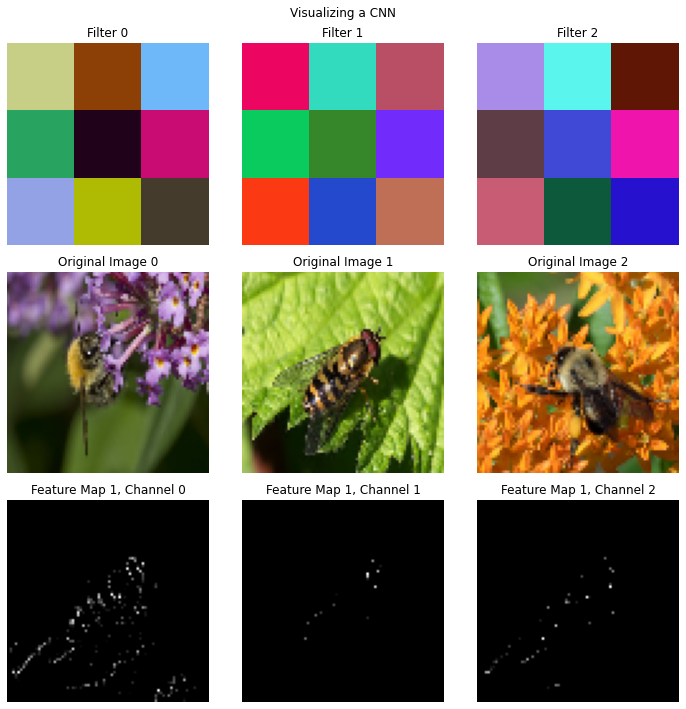

In [11]:
# Get the filters from the first layer of the model
filters = model.layers[0].get_weights()[0]

# Get the first batch of images from the training set
conv_images = X_train.take(1)
plt.figure(figsize=(10, 10))
for images, labels in conv_images:
    images = images.numpy()
    labels = labels.numpy()

# Get the feature maps from the first layer of the model
feature_maps = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)
feature_maps = feature_maps.predict(images)

# Normalize the filters and feature maps. This will make the images more clear.
normal_filters = (filters - filters.min()) / (filters.max() - filters.min())
normal_feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

# Display the filters, images and feature maps
plt.figure(figsize=(10, 10))

# ----- Filters -----
for i in range(3):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns, position 1 to 3 
    plt.imshow(normal_filters[:, :, :, i], cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')

# ----- Original Images -----
for i in range(3):
    plt.subplot(3, 3, i + 4)  # Position 4 to 6
    plt.imshow(images[i].astype("uint8"))
    plt.title(f'Original Image {i}')
    plt.axis('off')

# -----  Feature Maps (Image 1) -----
for i in range(3):
    plt.subplot(3, 3, i + 7)  # Position 7 to 9
    plt.imshow(normal_feature_maps[1, :, :, i], cmap='gray')
    plt.title(f'Feature Map 1, Channel {i}')
    plt.axis('off')

plt.suptitle('Visualizing a CNN')  # Overall title for the plot
plt.tight_layout()  # Adjust spacing to prevent overlaps
plt.show()


Just as with the other hyperparameters in Section 5 above, the number of filters, the size of the filters, and the stride of the filters are all hyperparameters that can be adjusted. You can also add or remove convolutional and pooling layers, or add dropout layers.


## 13. Dropout

Dropout layers are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. Here is an example of how to add a dropout layer to the model:
    
```python
   layers.Dropout(0.5) 
```

## 14. Padding and Stride for Convolutional Layers
To adjust the stride and padding of the convolutional layers, you can add the `strides` and `padding` arguments to the `Conv2D` layer. The `strides` argument is a tuple of two integers, specifying the strides of the convolution along the height and width. The `padding` argument can be either `'valid'` or `'same'`. `'valid'` means no padding, while `'same'` means the output feature map will have the same spatial dimensions as the input feature map. Here is an example of a convulutional layer with a stride of 2 and padding of `'same'`:
    
```python
    # Replacement Conv2D layer
    layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation=activation)
    # Replacement MaxPooling2D layer
    layers.MaxPooling2D((2, 2), padding='same', strides=(2, 2))
```

The cell below updates the `make_model` function to include dropout layers, and padding. Feel free to adjust these as you wish.

In [12]:
def make_model_2(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model_2()
model.summary()

def the_whole_shebang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_test = helpers_01.load_display_data(data_path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    
    # Set dropout variable to "W_dropout" now that we have added dropout to the model
    dropout = "W_dropout" 
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model, history = helpers_01.compile_train_model(X_train, X_test, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs, callbacks=tensorboard_callback)
    helpers_01.evaluate_model(X_train, X_test, model, history, classes)

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                        

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 64.
  - Resizing input images to: (80, 80, 3).
  - Returning class counts for later use? False
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


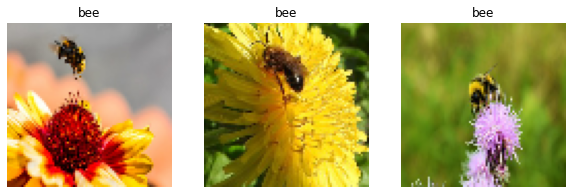

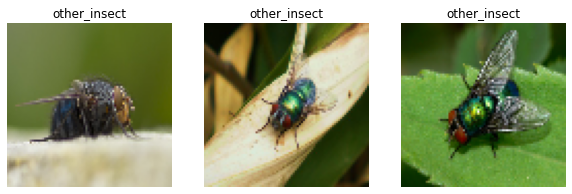

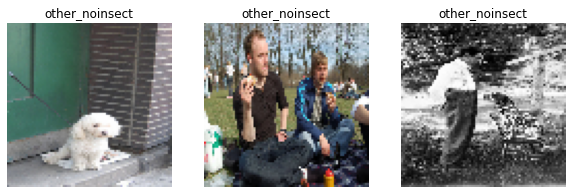

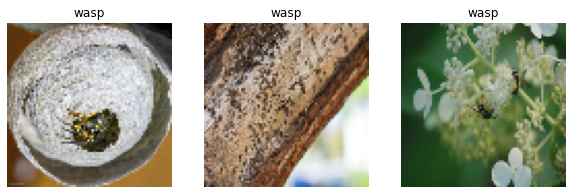


Getting number of images per class. This may take a bit...

For the Training set:
Category bee: 2552 images or 27.9% of total images.
Category other_insect: 1945 images or 21.3% of total images.
Category other_noinsect: 698 images or 7.6% of total images.
Category wasp: 3943 images or 43.1% of total images.
***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss function: <keras.losses.SparseCategoricalCrossentropy object at 0x147eff14a820>.
  - Using the optimizer: Adagrad.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
  - Using these callbacks: <keras.callbacks.TensorBoard object at 0x147e5dff4940>
********************************

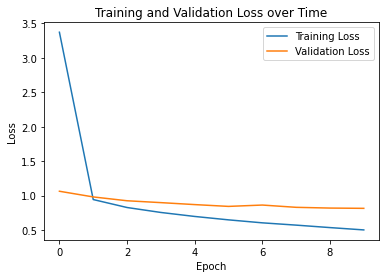

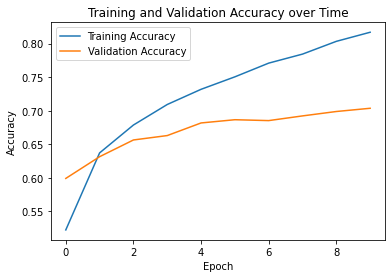

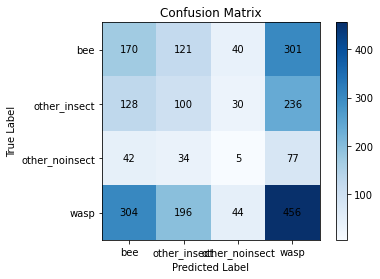

In [13]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 64  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=False) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

## 15. Conclusion

Well...50% dropout might be too much! Experiment and see what improvement you can make, but there is only so much hyperparameter tuning can do! Addressing the data is probably going to be more important in this case!

Using Tensorboard, you can keep track of what hyperparemeters are changed and monitor the impact of these changes on model training and performance. Once you are satisfied, contiune to the notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb).

## Bonus Exercise
If you found this exercise pretty simple, try editing the code in this notebook such that our function from Section 7 (*the_whole_shebang*) can control the Dropout rate, stride, and padding of the convolutional layers.